In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import os, sys
from sklearn.model_selection import train_test_split
from stareg.star_model import StarModel

### load data

In [2]:
path = "..\\..\\Data\\Table_alpha_Data.txt"
df = pd.read_csv(filepath_or_buffer=path)
df.columns = ["QDot", "T", "HTC"]

### preprocessing and train-test-split

In [3]:
df_min, df_max = df.min(), df.max()
df_mean, df_std = df.mean(), df.std()

df[["QDot_norm", "T_norm"]] = (df[["QDot", "T"]] - df_min[["QDot", "T"]]) / (df_max[["QDot", "T"]] - df_min[["QDot", "T"]])
df["HTC_std"] = (df["HTC"] - df_mean["HTC"]) / df_std["HTC"]

df_train, df_test = train_test_split(df[["QDot_norm", "T_norm", "HTC_std"]], train_size=0.75)
X, y = df[["QDot_norm", "T_norm"]].values, df["HTC_std"].values
X_train, y_train = df_train[["QDot_norm", "T_norm"]].values, df_train["HTC_std"].values
X_test, y_test = df_test[["QDot_norm", "T_norm"]].values, df_test["HTC_std"].values

### model defintion

In [4]:
m = ( ("s(1)", "inc", 50, (12, 6000), "quantile"), 
      ("s(2)", "peak", 50, (1, 6000), "quantile"), 
      ("t(1,2)", "smooth", (8,8), (1, 100), "equidistant"), )
M = StarModel(description=m)

### fit

In [5]:
M.fit(X=X, y=y, plot_=0)
print("MSE_train = ", M.mse)
M.eval_metric(X=X, y=y)

MSE_train =  0.2731901


0.63147

### plot

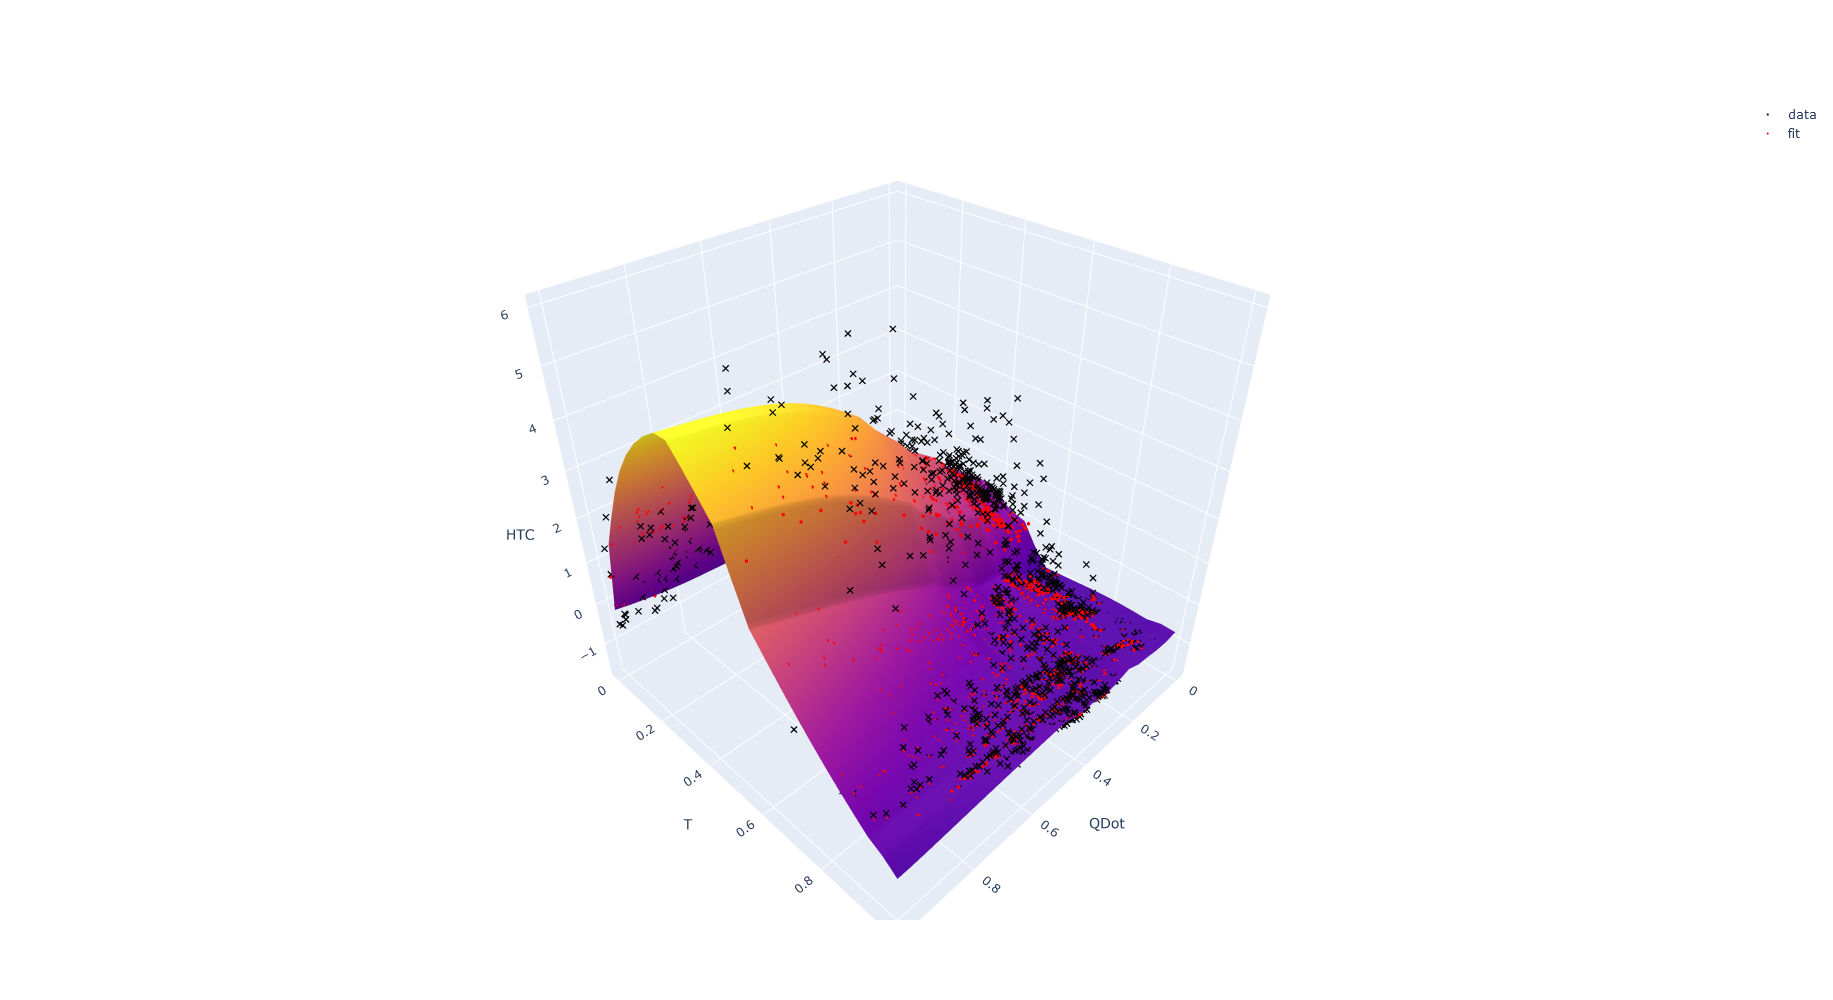

In [9]:
nplot = 25
xplot = np.linspace(0,1,nplot)
xplotgrid = np.meshgrid(xplot, xplot)
Xplot = np.vstack((xplotgrid[0].ravel(), xplotgrid[1].ravel())).T
yplot = M.predict(X=Xplot)


fig = go.Figure()
#fig.add_trace(go.Scatter3d(x=df["QDot"], y=df["T"], z=df["HTC"], mode="markers", marker=dict(size=2, color="black", symbol="x")))
fig.add_trace(go.Scatter3d(x=df["QDot_norm"], y=df["T_norm"], z=df["HTC_std"], mode="markers", marker=dict(size=2, color="black", symbol="x"), name="data"))
fig.add_trace(go.Scatter3d(x=X[:,0], y=X[:,1], z=M.basis @ M.coef_, mode="markers", marker=dict(size=2, color="red"), name="fit"))
# fig.add_trace(go.Mesh3d(x=Xplot[:,0], y=Xplot[:,1], z=yplot, name="fit", opacity=0.4, color="red"))
fig.add_trace(go.Surface(x=xplotgrid[0], y=xplotgrid[1], z=yplot.reshape(nplot, nplot), showscale=False) )

fig.layout.scene.xaxis.title = "QDot"
fig.layout.scene.yaxis.title = "T"
fig.layout.scene.zaxis.title = "HTC"
fig.update_layout(height=1000, width=1000)